# Weather data


In [2]:
import os
import pandas as pd
from eocrops.inputs.meteoblue import WeatherDownload
from eocrops.climatools.format_data import WeatherPostprocess

import geopandas as gpd
from shapely.geometry import Point

## Read the file

In [3]:
print(os.getcwd())
input_file = pd.read_csv("../data/burkina_dataframe.csv")
input_file["geometry"] = [
    Point(x, y) for x, y in zip(input_file["Longitude"], input_file["Latitude"])
]
input_file = gpd.GeoDataFrame(input_file)

input_file["Id_location"] = input_file["Id_location"].astype(str)
input_file["timestamp"] = [
    (f"{year}-01-01", f"{year}-12-31") for year in input_file["Year"]
]

input_file.head()

C:\Users\s999379\OneDrive - Syngenta\Documents\git-repo\eo-crops\examples


C:\Users\s999379\Miniconda3\envs\eo-crops\lib\site-packages\pandas\core\dtypes\cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,Year,Id_location,Latitude,Longitude,geometry,timestamp
0,2010,200026,14.0333,-0.0333,POINT (-0.03330 14.03330),"(2010-01-01, 2010-12-31)"
1,2010,200107,11.7333,-2.9167,POINT (-2.91670 11.73330),"(2010-01-01, 2010-12-31)"
2,2010,200140,10.3333,-3.1833,POINT (-3.18330 10.33330),"(2010-01-01, 2010-12-31)"
3,2010,200099,11.1667,-4.3000,POINT (-4.30000 11.16670),"(2010-01-01, 2010-12-31)"
4,2010,200089,12.0667,0.3500,POINT (0.35000 12.06670),"(2010-01-01, 2010-12-31)"


## Download data using meteoblue API

## Define the query 

In [5]:
# Define your query (https://docs.meteoblue.com/en/weather-apis/dataset-api/dataset-api)
## Daily statistics to extract
AGGREGATION = "mean"

## Query of variables
query = [
    {
        "domain": "ERA5",
        "gapFillDomain": "ERA5",
        "timeResolution": "daily",
        "codes": [
            {
                "code": 52,
                "level": "2 m above gnd",
                "aggregation": AGGREGATION,
            },  # Relative Humidity
            {
                "code": 11,
                "level": "2 m above gnd",
                "aggregation": AGGREGATION,
            },  # air temperature (°C)
            {
                "code": 32,
                "level": "2 m above gnd",
                "aggregation": AGGREGATION,
            },  # Wind Speed
            {
                "code": 256,
                "level": "sfc",
                "aggregation": AGGREGATION,
            },  # Diffuse Shortwave Radiation
            {
                "code": 56,
                "level": "2 m above gnd",
                "aggregation": AGGREGATION,
            },  # Vapor Pressure Deficit
            {
                "code": 260,
                "level": "2 m above gnd",
                "aggregation": AGGREGATION,
            },  # FAO Reference Evapotranspiration,
            {
                "code": 261,
                "level": "sfc",
                "aggregation": AGGREGATION,
            },  # Evapotranspiration
            {
                "code": 52,
                "level": "2 m above gnd",
                "aggregation": AGGREGATION,
            },  # Relative humidity
        ],
    }
]

In [ ]:
import nest_asyncio

nest_asyncio.apply()
## TODO : time interval subset by observations
time_interval = ("2017-01-01", "2017-12-31")

pipeline_cehub = WeatherDownload(
    api_key="",  # Please put your meteoblue API here
    shapefile=input_file,
    id_column="Id_location",
    timestamp_column="timestamp",
)

df_output = pipeline_cehub.execute(query=query);

In [9]:
df_output.head(5)

,location,lat,lon,asl,variable,unit,level,timeResolution,aggregation,timestamp,value,FD3C7D1A-5E1B-471B-9447-46EA81E18476
1,200026,13.91100,0.00000,294.786,Relative Humidity,%,2 m above gnd,daily,mean,20100101T0000,19.291204,FD3C7D1A-5E1B-471B-9447-46EA81E18476
2,200026,13.91100,0.00000,294.786,Relative Humidity,%,2 m above gnd,daily,mean,20100102T0000,17.51828,FD3C7D1A-5E1B-471B-9447-46EA81E18476
3,200026,13.91100,0.00000,294.786,Relative Humidity,%,2 m above gnd,daily,mean,20100103T0000,17.148224,FD3C7D1A-5E1B-471B-9447-46EA81E18476
4,200026,13.91100,0.00000,294.786,Relative Humidity,%,2 m above gnd,daily,mean,20100104T0000,18.082785,FD3C7D1A-5E1B-471B-9447-46EA81E18476
5,200026,13.91100,0.00000,294.786,Relative Humidity,%,2 m above gnd,daily,mean,20100105T0000,19.80562,FD3C7D1A-5E1B-471B-9447-46EA81E18476


In [10]:
df_output.to_csv("../data/weather_burkina.csv", index=False)

## Format the data for machine learning purposes.

In [11]:
AGGREGATION = "mean"
df_output = pd.read_csv("../data/weather_burkina.csv")

pipeline_refactor = WeatherPostprocess(
    shapefile=input_file,
    id_column="Id_location",
    resample_range=(
        "-01-01",
        "-12-31",
        1,  # You can even resample it using fixed periods of day (e.g. every 8 day)
    ),
)

df_mean = pipeline_refactor.execute(
    df_weather=df_output, stat=AGGREGATION, return_pivot=False
)

C:\Users\s999379\Miniconda3\envs\eo-crops\lib\site-packages\eocrops\climatools\format_data.py:160: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[["period", "location"]]


In [16]:
# Period is the number of day from the beginning of the query
## Name of the variables
print(df_mean.variable.unique())
## Check the dataframe ready-to-use
df_mean.head()

['Diffuse Shortwave Radiation' 'Evapotranspiration'
 'FAO Reference Evapotranspiration' 'Relative Humidity' 'Temperature'
 'Vapor Pressure Deficit' 'Wind Speed']


,variable,period,Id_location,Year,mean_value
0,Diffuse Shortwave Radiation,0.0,200001,2010,56.000000
32,Diffuse Shortwave Radiation,1.0,200001,2010,54.916668
64,Diffuse Shortwave Radiation,2.0,200001,2010,55.958332
96,Diffuse Shortwave Radiation,3.0,200001,2010,56.125000
128,Diffuse Shortwave Radiation,4.0,200001,2010,55.958332


<Axes: xlabel='period', ylabel='mean_value'>

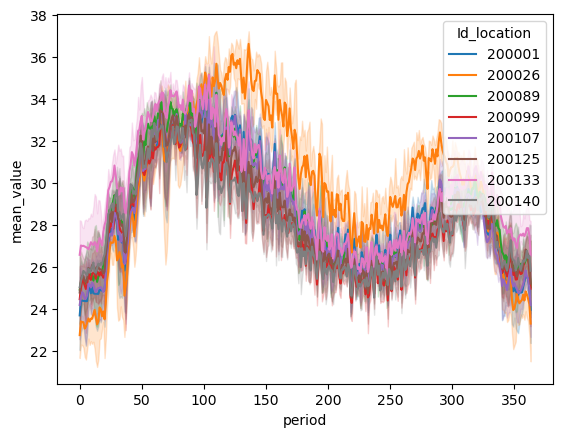

In [13]:
# Check the results
import seaborn as sns

df_temperature = df_mean[df_mean["variable"] == "Temperature"]
sns.lineplot(
    x="period", y=f"{AGGREGATION}_value", hue="Id_location", data=df_temperature
)